<a href="https://colab.research.google.com/github/kashifcodes92/CV-face_emotions/blob/main/cv_face_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# 📌 STEP 1: Install dependencies
!pip install keras tensorflow matplotlib scikit-learn

In [6]:
# 📌 STEP 2: Import libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
# 📌 STEP 3: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# 📌 STEP 4: Set Dataset Path (update if needed)
import os
DATASET_PATH = "/content/drive/MyDrive/fer2013"
train_path = os.path.join(DATASET_PATH, "train")
test_path = os.path.join(DATASET_PATH, "test")

In [9]:
# 📌 STEP 5: Preview folders in dataset
print("Train classes:", os.listdir(train_path))
print("Test classes:", os.listdir(test_path))

Train classes: ['disgust', 'surprise', 'fear', 'angry', 'neutral', 'sad', 'happy']
Test classes: ['fear', 'neutral', 'angry', 'disgust', 'surprise', 'happy', 'sad']


In [10]:
# 📌 STEP 6: Show random sample images
import cv2
import random

def show_random_images(folder, n=5):
    emotions = os.listdir(folder)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        emotion = random.choice(emotions)
        emotion_path = os.path.join(folder, emotion)
        image_name = random.choice(os.listdir(emotion_path))
        image_path = os.path.join(emotion_path, image_name)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.title(emotion)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

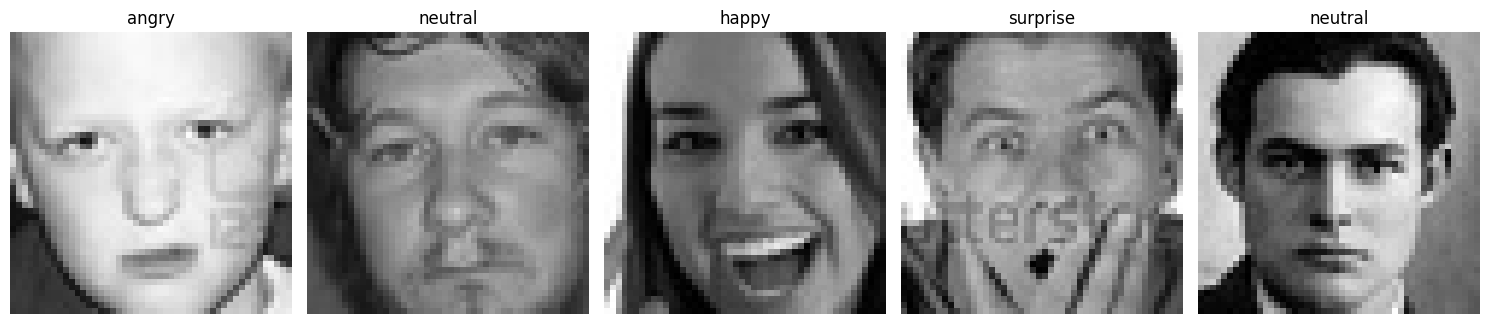

In [11]:
# 📌 STEP 7: Visualize training samples
show_random_images(train_path, n=5)

In [15]:
# 📌 STEP 8: Data Augmentation
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32  # Increased from 16 for faster training

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,    # Added for better augmentation
    height_shift_range=0.1,   # Added for better augmentation
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 23142 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [17]:
#🧠 STEP 9: Build CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),  # Added
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),  # Added
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),  # Added
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),  # Increased from 64
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,743 (1.36 MB)

 Trainable params: 356,295 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# 🛠 STEP 10: Compile & Train
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_emotion_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=30,  # Increased from 10
    validation_data=test_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/30
 97/724 ━━━━━━━━━━━━━━━━━━━━ 1:50:24 11s/step - accuracy: 0.1958 - loss: 2.7382

In [ ]:
# 📈 STEP 11: Evaluate
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

# Classification Report
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


In [ ]:
# 💾 STEP 12: Save Model
model.save('/content/emotion_model.h5')
print("✅ Model saved as emotion_model.h5")

In [ ]:
# STEP 13: Classification report (optional)
# Generate classification report
import numpy as np
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

from sklearn.metrics import classification_report, confusion_matrix
print("📊 Classification Report:")
print(classification_report(y_true, y_pred_classes))
